<a href="https://colab.research.google.com/github/srinirama/gesture_recognition/blob/main/Gesture%20Recognition-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Course Project - Gesture Recognition
Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs Up --> Increase the volume.
- Thumbs Down --> Decrease the volume.
- Left Swipe --> 'Jump' backwards 10 seconds.
- Right Swipe -->'Jump' forward 10 seconds.
- Stop --> Pause the movie.

Each video is a sequence of 30 frames (or images).

### Objectives:

##### Generator: 
The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

##### Model: 
Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

##### Write up:
This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.



In [ ]:
# importing the required libraries
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import abc
import cv2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from keras.models import Sequential, Model
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dropout
from tensorflow.keras import optimizers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
GESTURE_PATH="/content/gdrive/My Drive/Gesture/Project_data/"


We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [ ]:
# reading the training images data
train_doc = np.random.permutation(open('/content/gdrive/My Drive/Gesture/Project_data/train.csv').readlines())
# reading the validation image data
val_doc = np.random.permutation(open('/content/gdrive/My Drive/Gesture/Project_data/val.csv').readlines())
# setting the initial batch size
batch_size = 20
# storing the project folder path for reading the images
project_folder='/content/gdrive/My Drive/Gesture/Project_data'

##### Code for Plotting

In [ ]:
# defining a reusable method to plog the history for both training and validation dataset for analysis
def plot(history):
    """
    Method to plot for categoricak accuracy and loss for both training and validation dataset
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

Here We have defined `Class ModelBuilder` which has modulerised functions defined which would help in easy debugging also to call function on ModelBuilder Function So decreassing number of call function and number of coding steps.

In [ ]:
# defining a reusable class with methods to reduce the redundant code
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        """
        Method to initialize the training and validation dataset paths
        """
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        """
        method to initialize the image properties
        """
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        """
        Method to initialize the hyper parameters for the model
        """
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        """
        generator function which takes folder path and list of folders in the path
        @param source_path: source file path
        @param folder_list: list of folders available in the source file path
        @param agument: boolean flag to intimate whether agumentation is done or not
        """
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
        """
        Method to get the batch data from given data
        """
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))          
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        """
        Reusable method to training the model with given model instance
        """
#     get training data
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
#     getting validation data
        val_generator = self.generator(self.val_path, self.val_doc)
#     setting the model name
        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
#     checking the path is available, else creates the path
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
#     setting the .h5 file path
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'
#     setting the check point for the training model
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
#     storing the history of training
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
#     returning the history object
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
# storing the current time
curr_dt_time = datetime.datetime.now()
# storing training image path
train_path = '/home/datasets/Project_data/train'
# storing validation image path
val_path = '/home/datasets/Project_data/val'
# storing the number of folder in training folder
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
# storing the number of folder in validation folder
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# setting number of epochs
num_epochs = 15
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 15


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
# importing required libraries for model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

# reusable class to build a model
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        """
        reusable method to define a model with defined filter size, dense neurons and dropout layer
        """
#         taking a sequential model
        model = Sequential()
#     defining conv3d layer
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
#     using relu as activiation function
        model.add(Activation('relu'))
#     using normalization during model building
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
# getting the conv3d model
conv_3d1=ModelConv3D1()
# initializing the path's for model building
conv_3d1.initialize_path(project_folder)
# initializing the image properties
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
# initialize the hyper parameters for the model
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
# defining the model
conv_3d1_model=conv_3d1.define_model()
# printing the model summary
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 20, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_1 (Activation)   (None, 10, 80, 80, 32)    0

2022-05-18 05:50:31.038969: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-05-18 05:50:31.039032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [ ]:
# importing required library
from sys import getsizeof
# printing memory usable
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


From the above understanding we understood that too much memory is being utilised so we will refine the model 

- By trading-off between these parameters


Before checking on how batch size influences training data lets check on image sample cropping.

### Sample Cropping

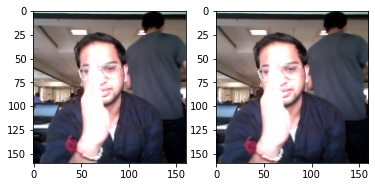

In [ ]:
# getting the sample model 
test_generator=ModelConv3D1()
# initializing the path's for model building
test_generator.initialize_path(project_folder)
# initializing the image properties
test_generator.initialize_image_properties(image_height=160,image_width=160)
# initialize the hyper parameters for the model
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

From the above image we can infer that orginal image at left is cropped and fit into diemensions as shown in right.

Let us try on experiments to see how training time is affected by image resolution, number of images in sequence and batch size.

In [ ]:
# getting the conv3d model 
conv_3d1=ModelConv3D1()
# initializing the path's for model building
conv_3d1.initialize_path(project_folder)
# initializing the image properties
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
# initialize the hyper parameters for the model
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
# defining the model
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
# training the model
conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/3


2022-05-18 05:50:39.256992: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 1.5506 - categorical_accuracy: 0.4555
Epoch 00001: saving model to model_init_2022-05-1805_50_33.561168/model-00001-1.55064-0.45551-2.61390-0.16000.h5
23/23 [==============================] - 100s 4s/step - loss: 1.5506 - categorical_accuracy: 0.4555 - val_loss: 2.6139 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 0.8920 - categorical_accuracy: 0.6667
Epoch 00002: saving model to model_init_2022-05-1805_50_33.561168/model-00002-0.89202-0.66667-4.30142-0.29000.h5
23/23 [==============================] - 99s 4s/step - loss: 0.8920 - categorical_accuracy: 0.6667 - val_loss: 4.3014 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.8081 - categorical_accuracy: 0.6923
Epoch 00003: saving model to model_init_2022-05-1805_50_33.561168/model-00003-0.80809-0.69231-4.74492-0.20000.h5
23/23 [================

In [ ]:
# getting the conv3d model 
conv_3d1=ModelConv3D1()
# initializing the path's for model building
conv_3d1.initialize_path(project_folder)
# initializing the image properties
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
# initializing hyper parameters
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=60,num_epochs=2)
# defining the model
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
# training the model
conv_3d1.train_model(conv_3d1_model)

Total Params: 592773
Epoch 1/2
12/12 [==============================] - ETA: 0s - loss: 1.5616 - categorical_accuracy: 0.4118 
Epoch 00001: saving model to model_init_2022-05-1805_55_32.264922/model-00001-1.56161-0.41176-1.68152-0.20000.h5
12/12 [==============================] - 165s 15s/step - loss: 1.5616 - categorical_accuracy: 0.4118 - val_loss: 1.6815 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/2
12/12 [==============================] - ETA: 0s - loss: 1.0954 - categorical_accuracy: 0.5445 
Epoch 00002: saving model to model_init_2022-05-1805_55_32.264922/model-00002-1.09543-0.54449-1.77347-0.19000.h5
12/12 [==============================] - 159s 14s/step - loss: 1.0954 - categorical_accuracy: 0.5445 - val_loss: 1.7735 - val_categorical_accuracy: 0.1900 - lr: 0.0010


In [ ]:
# getting the conv3d model 
conv_3d1=ModelConv3D1()
# initializing the path's for model building
conv_3d1.initialize_path(project_folder)
# initializing the image properties
conv_3d1.initialize_image_properties(image_height=120,image_width=120)
# initializing the hyper parameters
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
# defining the model
conv_3d1_model=conv_3d1.define_model()t
# training the model
conv_3d1.train_model(conv_3d1_model)

Total Params: 699269
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6208 - categorical_accuracy: 0.3967
Epoch 00001: saving model to model_init_2022-05-1806_01_08.428840/model-00001-1.62082-0.39668-3.03493-0.15000.h5
67/67 [==============================] - 166s 2s/step - loss: 1.6208 - categorical_accuracy: 0.3967 - val_loss: 3.0349 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2424 - categorical_accuracy: 0.5385
Epoch 00002: saving model to model_init_2022-05-1806_01_08.428840/model-00002-1.24245-0.53846-4.14509-0.27000.h5
67/67 [==============================] - 166s 3s/step - loss: 1.2424 - categorical_accuracy: 0.5385 - val_loss: 4.1451 - val_categorical_accuracy: 0.2700 - lr: 0.0010


In [ ]:
# getting the conv3d model 
conv_3d1=ModelConv3D1()
# initializing the path's for model building
conv_3d1.initialize_path(project_folder)
# initializing the image properties
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
# initializing the hyper parameters
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
# defining the model
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
# training the model
conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.5721 - categorical_accuracy: 0.4012
Epoch 00001: saving model to model_init_2022-05-1806_06_43.626525/model-00001-1.57207-0.40121-2.31269-0.17000.h5
67/67 [==============================] - 186s 3s/step - loss: 1.5721 - categorical_accuracy: 0.4012 - val_loss: 2.3127 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2580 - categorical_accuracy: 0.5204
Epoch 00002: saving model to model_init_2022-05-1806_06_43.626525/model-00002-1.25803-0.52036-2.42814-0.22000.h5
67/67 [==============================] - 185s 3s/step - loss: 1.2580 - categorical_accuracy: 0.5204 - val_loss: 2.4281 - val_categorical_accuracy: 0.2200 - lr: 0.0010


### Observation from the above experiement
- From the above experiments image resolution and number of frames in sequence have greater impact on training time than batch_size.
- So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . 
- Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes
- We will change the resoulution 160160, 120120 according the model performance

## Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [ ]:
# reuable class to building the 3d model
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):
        """
        reusable method to define a model with defined filter size, dense neurons and dropout layer
        """
        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# building the conv3d model
conv_3d1=ModelConv3D1()
# initializing the paths
conv_3d1.initialize_path(project_folder)
# initializing the image properties
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
# initializing the hyper parameters
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
# defining the model
conv_3d1_model=conv_3d1.define_model()
# printing the model summary
conv_3d1_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_20 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_30 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_21 (Activation)  (None, 10, 80, 80, 32)   

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
# training the model
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.5309 - categorical_accuracy: 0.4404
Epoch 00001: saving model to model_init_2022-05-1806_12_57.151430/model-00001-1.53093-0.44042-2.33904-0.16000.h5
17/17 [==============================] - 125s 8s/step - loss: 1.5309 - categorical_accuracy: 0.4404 - val_loss: 2.3390 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 0.8756 - categorical_accuracy: 0.6712
Epoch 00002: saving model to model_init_2022-05-1806_12_57.151430/model-00002-0.87559-0.67119-4.91998-0.17000.h5
17/17 [==============================] - 120s 7s/step - loss: 0.8756 - categorical_accuracy: 0.6712 - val_loss: 4.9200 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.5955 - categorical_accuracy: 0.8024
Epoch 00003: saving model to model_init_2022-05-1806_12_57.151430/model-00003-0.59553-0.80241-5.9459

> we can observe that training accuracy and validation accuravy are no where near and it seems that the model is overfitted

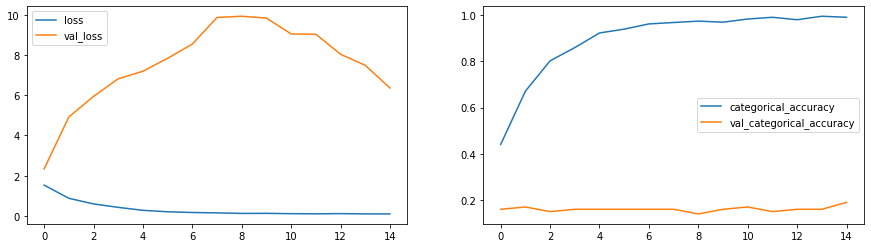

In [ ]:
# plotting the history of the training model
plot(history_model1)

> We can clearly see on above plot that validation accuracy is very low and training accuracy is very high

Model is clearly overfitting. So we need to do data augmentation

## Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [ ]:
# getting the conv3d model 
conv_3d2=ModelConv3D1()
# initializing the project files path
conv_3d2.initialize_path(project_folder)
# initializing the image properties
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
# initializing the hyper parameters
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
# defining the model
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
# printing the model summary
conv_3d2_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_24 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_36 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_25 (Activation)  (None, 10, 80, 80, 32)   

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
# training the model
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9401 - categorical_accuracy: 0.3959
Epoch 00001: saving model to model_init_2022-05-1806_43_16.738088/model-00001-1.94011-0.39593-2.93478-0.16000.h5
34/34 [==============================] - 231s 7s/step - loss: 1.9401 - categorical_accuracy: 0.3959 - val_loss: 2.9348 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3110 - categorical_accuracy: 0.5490
Epoch 00002: saving model to model_init_2022-05-1806_43_16.738088/model-00002-1.31100-0.54902-3.73535-0.21000.h5
34/34 [==============================] - 221s 7s/step - loss: 1.3110 - categorical_accuracy: 0.5490 - val_loss: 3.7354 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1335 - categorical_accuracy: 0.6146
Epoch 00003: saving model to model_init_2022-05-1806_43_16.738088/model-00003-1.13347-0.61463-5.2389

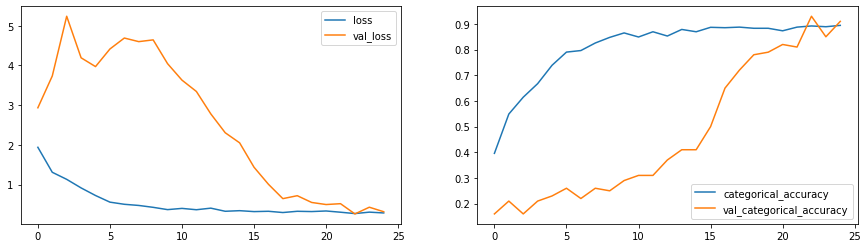

In [ ]:
# plotting the model training history
plot(history_model2)

Model has comparitively improved, as we get a best validation accuracy of 89% and training accuracy of 91%. 

## Model 3 - Reduce filter size to (2,2,2) and image res to 120 x 120

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# getting the conv3d model
conv_3d3=ModelConv3D3()
# initializing paths
conv_3d3.initialize_path(project_folder)
# initialing the image properties
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
# initilizing hyper parameters
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
# defining the model
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
# printing the model summary
conv_3d3_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_28 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_42 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_29 (Activation)  (None, 8, 60, 60, 32)    

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
# training the model
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.1454 - categorical_accuracy: 0.3160
Epoch 00001: saving model to model_init_2022-05-1808_15_05.197299/model-00001-2.14542-0.31599-1.76026-0.20000.h5
23/23 [==============================] - 155s 7s/step - loss: 2.1454 - categorical_accuracy: 0.3160 - val_loss: 1.7603 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5244 - categorical_accuracy: 0.4789
Epoch 00002: saving model to model_init_2022-05-1808_15_05.197299/model-00002-1.52442-0.47888-2.13973-0.19000.h5
23/23 [==============================] - 157s 7s/step - loss: 1.5244 - categorical_accuracy: 0.4789 - val_loss: 2.1397 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.2171 - categorical_accuracy: 0.5573
Epoch 00003: saving model to model_init_2022-05-1808_15_05.197299/model-00003-1.21714-0.5573

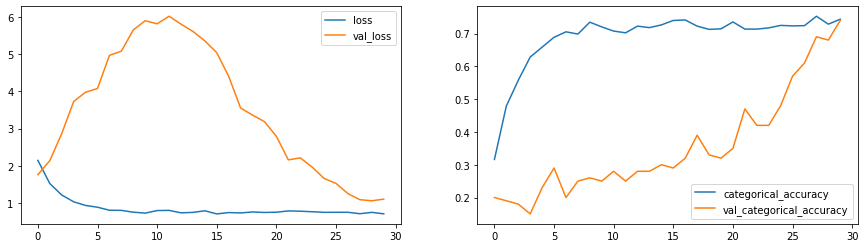

In [ ]:
# plotting the training history
plot(history_model3)

Model has a final validation accuracy of 74.36% and training accuracy of 74% . Also we were able to reduce the parameter size by half the earlier model.

> model final accuracy is matching but the initial accuracy is not near

## Model 4 - Adding more layers

In [ ]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# getting conv3d model 
conv_3d4=ModelConv3D4()
# initializing the paths
conv_3d4.initialize_path(project_folder)
# initializing the image properties
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
# initializing the hyper parameters
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
# defining the model 
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
# printing the model
conv_3d4_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_32 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_32 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_48 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_33 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_33 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_49 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [ ]:
print("Total Params:", conv_3d4_model.count_params())
# training the model
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9840 - categorical_accuracy: 0.3718
Epoch 00001: saving model to model_init_2022-05-1809_32_46.199928/model-00001-1.98402-0.37179-5.46319-0.18000.h5
34/34 [==============================] - 163s 5s/step - loss: 1.9840 - categorical_accuracy: 0.3718 - val_loss: 5.4632 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4959 - categorical_accuracy: 0.4992
Epoch 00002: saving model to model_init_2022-05-1809_32_46.199928/model-00002-1.49593-0.49925-2.92866-0.29000.h5
34/34 [==============================] - 156s 5s/step - loss: 1.4959 - categorical_accuracy: 0.4992 - val_loss: 2.9287 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3839 - categorical_accuracy: 0.5189
Epoch 00003: saving model to model_init_2022-05-1809_32_46.199928/model-00003-1.38386-0.51885-5.6448

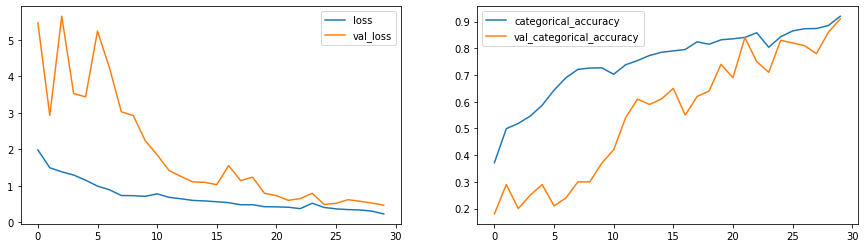

In [ ]:
# plotting the history of the model training
plot(history_model4)

With more layers we see performance improvement in terms of accuracy. We get a best validation accuracy of 92% . Let's try adding dropouts at the convolution layers see the performance of model

## Model 5 Adding dropout at convolution layers

In [ ]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# getting the model
conv_3d5=ModelConv3D5()
# initializing the paths
conv_3d5.initialize_path(project_folder)
# initializing the image properties
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
# initializing the hyper parameters
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
# defining the model
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
# printing the model summary
conv_3d5_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_58 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_41 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_41 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_59 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                     

In [ ]:
print("Total Params:", conv_3d5_model.count_params())
# training the model
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.7088 - categorical_accuracy: 0.4087
Epoch 00001: saving model to model_init_2022-05-1810_51_49.654728/model-00001-1.70882-0.40875-1.69030-0.21000.h5
34/34 [==============================] - 160s 5s/step - loss: 1.7088 - categorical_accuracy: 0.4087 - val_loss: 1.6903 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.2152 - categorical_accuracy: 0.5302
Epoch 00002: saving model to model_init_2022-05-1810_51_49.654728/model-00002-1.21522-0.53017-2.42870-0.14000.h5
34/34 [==============================] - 159s 5s/step - loss: 1.2152 - categorical_accuracy: 0.5302 - val_loss: 2.4287 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.0594 - categorical_accuracy: 0.5935
Epoch 00003: saving model to model_init_2022-05-1810_51_49.654728/model-00003-1.05944-0.59351-3.1389

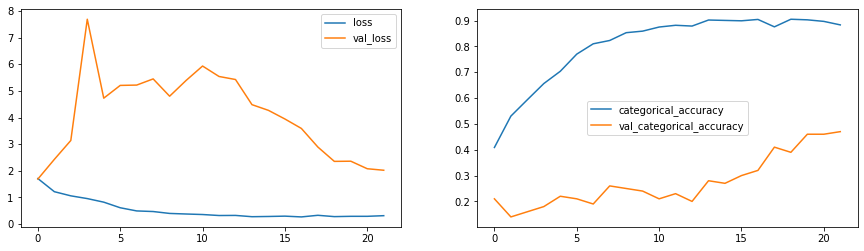

In [ ]:
# plotting the model history
plot(history_model5)

Adding dropouts has further reduced validation accuracy as its not to learn generalizable features
All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

### Model 6 - Reducing the number of parameters

In [ ]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# getting the model
conv_3d6=ModelConv3D6()
# initializing the paths
conv_3d6.initialize_path(project_folder)
# initializing the image properties
conv_3d6.initialize_image_properties(image_height=120,image_width=120)
# initializing the hyper paramters
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=20)
# defining the model
conv_3d6_model=conv_3d4.define_model(dense_neurons=64,dropout=0.25)
# printing the model summary
conv_3d6_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_48 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_68 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_49 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_49 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_69 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [ ]:
print("Total Params:", conv_3d6_model.count_params())
# training the model
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 1287989
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 0.3958 - categorical_accuracy: 0.8605
Epoch 00001: saving model to model_init_2022-05-1812_12_31.872941/model-00001-0.39581-0.86048-3.41991-0.27000.h5
34/34 [==============================] - 159s 5s/step - loss: 0.3958 - categorical_accuracy: 0.8605 - val_loss: 3.4199 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 0.3239 - categorical_accuracy: 0.8959
Epoch 00002: saving model to model_init_2022-05-1812_12_31.872941/model-00002-0.32389-0.89593-3.54917-0.27000.h5
34/34 [==============================] - 159s 5s/step - loss: 0.3239 - categorical_accuracy: 0.8959 - val_loss: 3.5492 - val_categorical_accuracy: 0.2700 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.3225 - categorical_accuracy: 0.8869
Epoch 00003: saving model to model_init_2022-05-1812_12_31.872941/model-00003-0.32245-0.8868

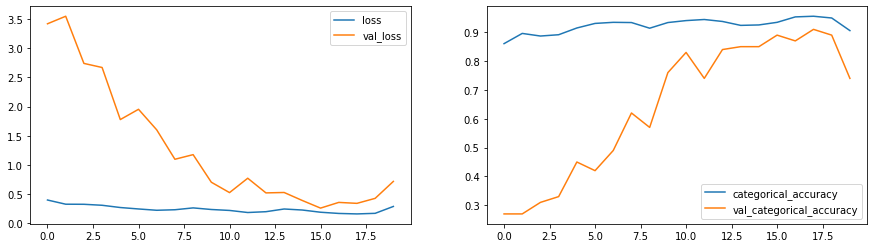

In [ ]:
# plotting the model training history
plot(history_model6)

For the above low memory foot print model the best validation accuracy of 90% which is slightly improvised than earlier model and still the overfitting is there

### Model 7 - CNN- LSTM Model

In [ ]:

class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# getting rnn model
rnn_cnn1=RNNCNN1()
# initializing the paths
rnn_cnn1.initialize_path(project_folder)
# initializing the image properties
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
# initializing the hyper parameters
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=30)
# defining the model
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
# printing the model summary
rnn_cnn1_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32) 

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
# training the model
history_model7=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.3673 - categorical_accuracy: 0.4103
Epoch 00001: saving model to model_init_2022-05-1813_04_36.180969/model-00001-1.36732-0.41026-1.66819-0.29000.h5
34/34 [==============================] - 185s 6s/step - loss: 1.3673 - categorical_accuracy: 0.4103 - val_loss: 1.6682 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.0261 - categorical_accuracy: 0.5890
Epoch 00002: saving model to model_init_2022-05-1813_04_36.180969/model-00002-1.02613-0.58899-1.95392-0.20000.h5
34/34 [==============================] - 179s 5s/step - loss: 1.0261 - categorical_accuracy: 0.5890 - val_loss: 1.9539 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9254 - categorical_accuracy: 0.6305
Epoch 00003: saving model to model_init_2022-05-1813_04_36.180969/model-00003-0.92537-0.63047-2.4594

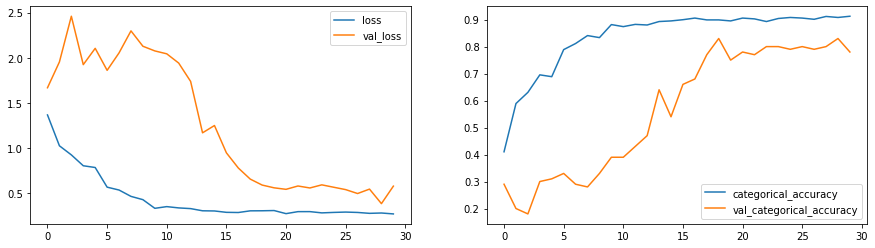

In [ ]:
# plotting the model training history
plot(history_model7)

For CNN - LSTM model we get a best validation accuracy of 91%. When compared to previous models where we have reduced the parameters. 
We can experiment on understanding augmentation of the data with slight rotation as well and run the same set of models again. Here we can observe how augmentation influences the performance.

## More Augmentation

In [ ]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass


## Model 8 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [ ]:
class ModelConv3D8(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
# getting the model
conv_3d8=ModelConv3D8()
# initializing the paths
conv_3d8.initialize_path(project_folder)
# initializing the image properties
conv_3d8.initialize_image_properties(image_height=160,image_width=160)
# initializing the hyper parameters
conv_3d8.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
# defining the model
conv_3d8_model=conv_3d8.define_model(dense_neurons=256,dropout=0.5)
# printing the model
conv_3d8_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_83 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_57 (Activation)  (None, 10, 80, 80, 32)  

In [ ]:
print("Total Params:", conv_3d8_model.count_params())
# training the model
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9889 - categorical_accuracy: 0.3394
Epoch 00001: saving model to model_init_2022-05-1814_33_06.241854/model-00001-1.98890-0.33937-2.43483-0.16000.h5
34/34 [==============================] - 237s 7s/step - loss: 1.9889 - categorical_accuracy: 0.3394 - val_loss: 2.4348 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5131 - categorical_accuracy: 0.4804
Epoch 00002: saving model to model_init_2022-05-1814_33_06.241854/model-00002-1.51311-0.48039-4.64868-0.22000.h5
34/34 [==============================] - 227s 7s/step - loss: 1.5131 - categorical_accuracy: 0.4804 - val_loss: 4.6487 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2573 - categorical_accuracy: 0.5747
Epoch 00003: saving model to model_init_2022-05-1814_33_06.241854/model-00003-1.25732-0.5746

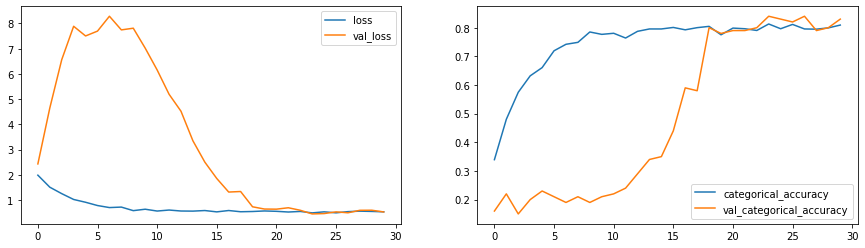

In [ ]:
plot(history_model8)

Rotation Data Augmentation with (3,3,3) Filter & 160x160 Image resolution has Val Accuracy is 80%. Comparitively less than Model 7 Accuracy of 91%.

### Model 9 - Transfer Learning with GRU and training all weights

In [ ]:
# importing the required libraries for transfer learning
from keras.applications import mobilenet
# taking mobilenet model
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
# getting mobilenet model
rnn_cnn_tl2=RNNCNN_TL2()
# initializing the paths
rnn_cnn_tl2.initialize_path(project_folder)
# initializing the image properties
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
# initializing the hyper paramters
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
# defining the model
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
# printing model summary
rnn_cnn_tl2_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru (GRU)                   (None, 128)             

In [ ]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
# training the model
history_model12=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.0863 - categorical_accuracy: 0.5641
Epoch 00001: saving model to model_init_2022-05-1816_48_56.019371/model-00001-1.08634-0.56410-0.41105-0.86000.h5
133/133 [==============================] - 165s 1s/step - loss: 1.0863 - categorical_accuracy: 0.5641 - val_loss: 0.4111 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.6430 - categorical_accuracy: 0.7783
Epoch 00002: saving model to model_init_2022-05-1816_48_56.019371/model-00002-0.64296-0.77828-0.46106-0.83000.h5
133/133 [==============================] - 156s 1s/step - loss: 0.6430 - categorical_accuracy: 0.7783 - val_loss: 0.4611 - val_categorical_accuracy: 0.8300 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.4731 - categorical_accuracy: 0.8454
Epoch 00003: saving model to model_init_2022-05-1816_48_56.019371/model-00003-0.47309-0.84

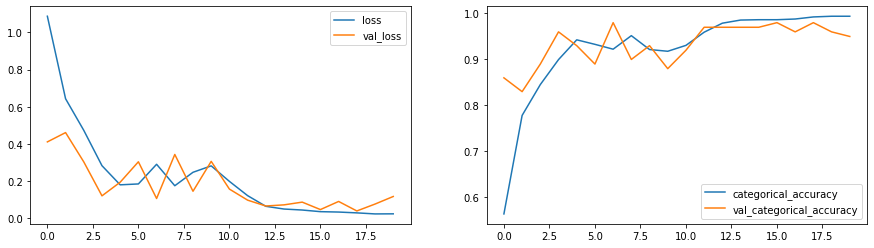

In [ ]:
# plotting the model training
plot(history_model12)

`Transfer Learning` - has got very good result for the model.
- From the above graph
    - We observe less overfitting.
    - The model built also is in unison with Training and Validation data.
    - Training Accuracy is 99% and Validation Accuracy is 95%.